# Exploring a vector database of sentence embeddings. 

As an example we use the IMDB data set as indexed by embeddings from the 'all-MiniLM-L6-v2' sentenceTransformer model---a set of 50,000 items of 384 features. 

To download the dataset, go to: 

    https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences


You need to download the "sentiment_labelled_sentences.zip" file  - 84 kb 

This is a 'supervised' dataset, with two columns separated by a tab, the first with unstructured text taken from a review of an unspecified movie, the second with a sentiment label, either 1 (positive) or 0 (negative). 

This notebook shows how to transform the dataset to include a column containing the vector embeddings of the unstructured text. 

Class 7: 7 March
JMA Feb 2024

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la 
import os
import glob
from pathlib import Path

import seaborn as sns

# We'll use this dataset of 3000 labeled text samples. 
# https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

# For converting the text into vectors, use this llm package 
# See https://pypi.org/project/sentence-transformers/
try:
    from sentence_transformers import SentenceTransformer
except:
    
    os.system('python -m pip install sentence-transformers')
    from sentence_transformers import SentenceTransformer
    
# The random number generator can be used to select a random set of columns for regression
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

In [2]:
# constants and other setup

# Choose one of the sentence transformer LLM models 
ST_MODEL = 'all-MiniLM-L6-v2'
EMBEDDING_DIMENSIONS = 384     # This model creates vectors of this length. 

# Change this to the place you store your data. 
DATA_DIR = Path('/Users/jma/sandbox/embeddings')

# The place you put the sentence data
SENTENCE_DIR = Path('sentiment labelled sentences')

# Store your featurized data so you don't have to transform it each time
featurized_data_file = Path('sentence_embeddings.parquet')

In [3]:
# Load the existing IMDB vectorized data
existing_db = DATA_DIR / featurized_data_file
if  (existing_db).exists():
    text_df = pd.read_parquet(DATA_DIR / Path(featurized_data_file)) 
    print('Reading ', featurized_data_file)
    text_df.head()
else:
    # Read the 3 datafiles
    text_df = pd.DataFrame(columns=['review', 'sentiment'])
    for a_file in (DATA_DIR / SENTENCE_DIR).glob('*.txt'):
        if 'readme' not in str(a_file): 
            df = pd.read_csv(a_file, sep = '\t',  header=None)
            df.columns = ['review', 'sentiment']
            print('reading ', a_file, ' with shape ', df.shape)
            text_df = pd.concat([text_df, df], axis=0)
    # Generate the embeddings
    print('Featurizing data')   # This will take about a minute. 
    sentxformer = SentenceTransformer(ST_MODEL)
    text_df['vector'] = sentxformer.encode(text_df['review'].values).tolist()
    # Save the result for next time
    text_df.to_parquet(DATA_DIR / featurized_data_file)

text_df.head()

Reading  sentence_embeddings.parquet


,review,sentiment,vector
0,So there is no way for me to plug it in here i...,0,"[0.08027008920907974, -0.04396028444170952, -0..."
1,"Good case, Excellent value.",1,"[-0.009648566134274006, 0.10622689127922058, 0..."
2,Great for the jawbone.,1,"[-0.07081733644008636, 0.07361650466918945, 0...."
3,Tied to charger for conversations lasting more...,0,"[-0.0739610344171524, 0.06734045594930649, 0.0..."
4,The mic is great.,1,"[-0.09819574654102325, 0.010798277333378792, 0..."


In [4]:
# Extract the vector field and expand it to multiple rows. 
n_samples, embedding_dim = text_df.shape
sample_ar = np.empty((n_samples, EMBEDDING_DIMENSIONS), 'float')
for i in range(n_samples):
    x = text_df.values[i,2]
    sample_ar[i] = x 
    
sample_ar.shape

(2748, 384)

In [5]:
all_samples = np.hstack([text_df['sentiment'][:,np.newaxis], sample_ar])

/var/folders/x3/t7qpngm57q96p9wxzg9rqv6h0000gp/T/ipykernel_29531/2441634733.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  all_samples = np.hstack([text_df['sentiment'][:,np.newaxis], sample_ar])


## Select a few vectors, and explore their similarity

To get a sense of the subspaces these vectors represent, we create the similarity matrix (all inner-products) for a few of the embeddings



In [6]:
# Two sets, one of positive and one of negative sentiment

how_many = 10
choices = np.random.choice(np.arange(EMBEDDING_DIMENSIONS), how_many, replace=False)

positive_samples = all_samples[all_samples[:,0] == 1, 1:][choices, :]
negative_samples = all_samples[all_samples[:,0] == 0, 1:][choices, :]

# Check their lengths
np.apply_along_axis(la.norm, 1, positive_samples), np.apply_along_axis(la.norm, 1, negative_samples)

(array([0.99999997, 0.99999997, 1.00000001, 0.99999997, 0.99999999,
        1.00000004, 1.        , 0.99999995, 1.00000002, 0.99999997]),
 array([0.99999998, 0.99999996, 0.99999999, 0.99999998, 1.00000002,
        0.99999999, 1.00000002, 1.00000002, 1.        , 0.99999996]))

<AxesSubplot:>

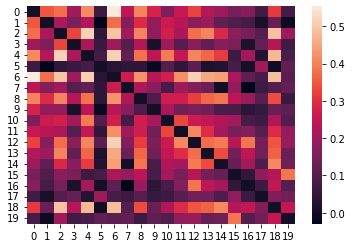

In [7]:
# Visualize how the vectors fill the space 
# Note how the embeddings are far from orthogonal! 
# Also the positive embeddings are "closer" than the negative. 
samples = np.vstack([positive_samples, negative_samples])
distances = samples @ samples.T
# Remove the diagonal (it's all == 1), to highlight the correlations 
np.fill_diagonal(distances, 0)
sns.heatmap(distances)

In [8]:
# Select one item as a target, and build an index to find distances

n_samples, em_dimension = sample_ar.shape

embedding_index = HNSWIndex(em_dimension, "usize")

target = rng.choice(n_samples)

for i in range(n_samples):
    if i != target:
        # Add an embedding vector to the index
        a_sample = np.float32(sample_ar[i,:])
        # print(a_sample.shape, type(a_sample))
        embedding_index.add(a_sample,i)
    else:
        chosen = np.float32(sample_ar[i,:])
        
embedding_index.build('euclidean')


NameError: name 'HNSWIndex' is not defined

In [ ]:
%%time
y = embedding_index.search(chosen,49999)
# Lookup all samples in order of distance 
y[:10]

In [ ]:
%%time
distances = np.empty((n_samples,))

for i in range(n_samples):
    distances[i] = np.dot(chosen, sample_ar[i])
# Making a comparison with just running a linear traversal via dot products through the data


In [ ]:
%%time
d2 = distances.copy()
d2.sort()
d2[:-10]
# Comparison - to be fair the time to sort the distances should be counted. 

In [ ]:
# Range of dot product values
pd.DataFrame(distances).describe()